<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5033 entries, 0 to 5032
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   5033 non-null   float64
dtypes: float64(1)
memory usage: 39.4 KB


<ipython-input-1-1a4d7dbb457f>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_ypf['Close'] = scaler.fit_transform(price_ypf['Close'].values.reshape(-1,1))


x_train.shape =  (4006, 24, 1)
y_train.shape =  (4006, 1)
x_test.shape =  (1002, 24, 1)
y_test.shape =  (1002, 1)
Epoch  0 MSE:  0.18762801587581635
Epoch  1 MSE:  0.1388568878173828
Epoch  2 MSE:  0.05429084971547127
Epoch  3 MSE:  0.024960417300462723
Epoch  4 MSE:  0.018393920734524727
Epoch  5 MSE:  0.0960678905248642
Epoch  6 MSE:  0.020897334441542625
Epoch  7 MSE:  0.07310796529054642
Epoch  8 MSE:  0.06077134981751442
Epoch  9 MSE:  0.025052402168512344
Epoch  10 MSE:  0.01780393347144127
Epoch  11 MSE:  0.029653752222657204
Epoch  12 MSE:  0.01887907274067402
Epoch  13 MSE:  0.006404121406376362
Epoch  14 MSE:  0.016285449266433716
Epoch  15 MSE:  0.020602772012352943
Epoch  16 MSE:  0.010981806553900242
Epoch  17 MSE:  0.004056271631270647
Epoch  18 MSE:  0.005733237601816654
Epoch  19 MSE:  0.010891161859035492
Epoch  20 MSE:  0.013018129393458366
Epoch  21 MSE:  0.009825645945966244
Epoch  22 MSE:  0.00428589154034853
Epoch  23 MSE:  0.0013721336144953966
Epoch  24 MSE:  0.

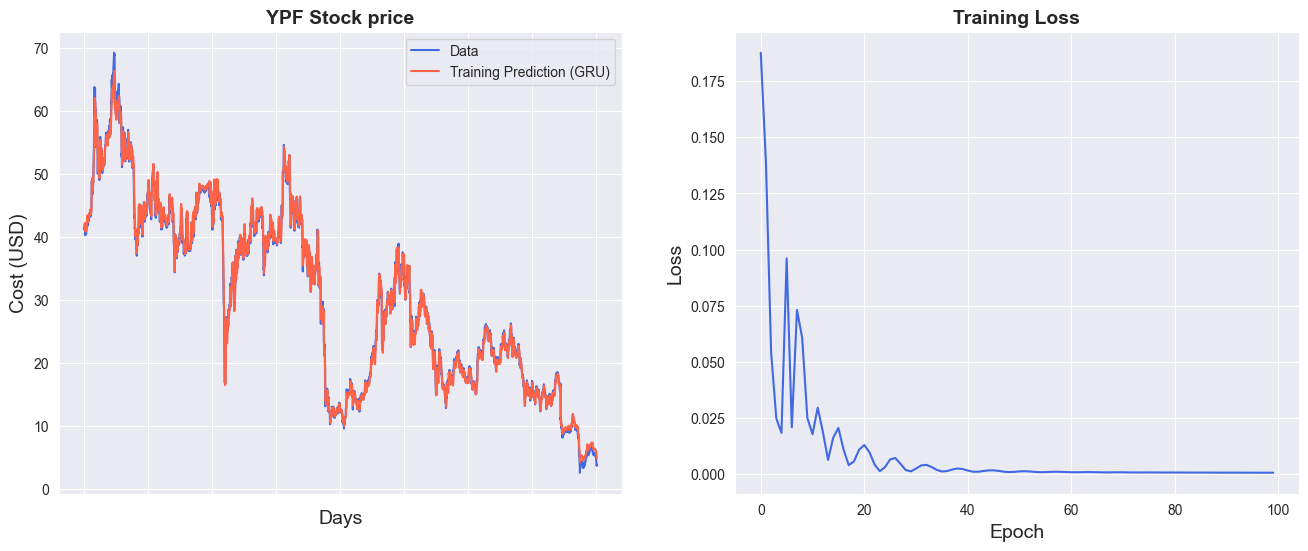

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as snsy
import numpy as np
import time

#MODELADO DE DATOS
#lectura de datos
filepath = 'YPF.csv'
data_ypf = pd.read_csv(filepath)
data_ypf = data_ypf.sort_values('Date')
data_ypf.head()

price_ypf = data_ypf[['Close']]
price_ypf.info()


# Escalado de datos
from splitData import split_data as spl
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price_ypf['Close'] = scaler.fit_transform(price_ypf['Close'].values.reshape(-1,1))

lookback = 25                       # choose sequence length
x_train, y_train, x_test, y_test = spl(price_ypf, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

# Carga de tensores

import torch

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
#y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
#y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

# Inicializado de modelo

from gruModel import GRU

input_dim = 1
hidden_dim = 32
num_layers = 3
output_dim = 1
num_epochs = 100

model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_gru)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))

# Ploteos

from ploteoTrainingModel import ploteo

ploteo(original=original, predict=predict, hist=hist)

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_gru.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_gru.detach().numpy())

# calculate root mean squared error

import math
from sklearn.metrics import mean_squared_error

trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
gru.append(trainScore)
gru.append(testScore)
gru.append(training_time)


# shift train predictions for plotting
trainPredictPlot = np.empty_like(price_ypf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price_ypf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price_ypf)-1, :] = y_test_pred

original = scaler.inverse_transform(price_ypf['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

future_predictions = []
last_x = x_test[-1:]  # Tomamos la última secuencia del conjunto de prueba como inicio

for _ in range(400):
    # Realizar predicción
    prediction = model(last_x)

    # Agregar la predicción a la lista
    future_predictions.append(prediction.item())
    
    # Crear la nueva secuencia para la próxima predicción
    last_x = torch.cat((last_x[:, 1:], prediction.view(1, 1, 1)), dim=1)

# Invertir la normalización para obtener el precio original
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

#Array para ploteo
futurePredictPlot = np.empty_like(price_ypf)
futurePredictPlot[:, :] = np.nan
futurePredictPlot= np.concatenate((futurePredictPlot,future_predictions), axis=0)

# Crear un DataFrame para las predicciones futuras
future_df = pd.DataFrame(futurePredictPlot, columns=[3])
#future_df.index = pd.date_range(start=y_test[-1] + pd.Timedelta(days=1), periods=50)

# Concatenar los DataFrames para la visualización
result = pd.concat([result, future_df], axis=1)

import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[3],
                    mode='lines',
                    name='Future Predictions')))

fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)
fig.update_xaxes(range=[result.index.min(), result.index.max()])


annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='YPF Stock Result',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()